In [347]:
import scipy
from scipy import linalg
import numpy as np
import timeit
import matplotlib.pyplot as plt
import seaborn as sns

# 3d Tensor CP decomposition

In [753]:
def tensor_CP(X, rank, max_iter=1000, tol=1e-5):


    normX = linalg.norm(X)
    U = np.array(create_random_tensor(X.shape, rank, normX))


    rel_er, converge_step = 1, tol * 10

    iter = 0
    history = [(rel_er, converge_step, 0)]


    while iter < max_iter and converge_step > tol:
        iter += 1

        # итерируемся по каждой размерности тензора
        for n in range(X.ndim):
            
            # развертываем матрицу 
            unfold = np.moveaxis(X, n, 0).reshape((X.shape[n], -1))

            # Выбираем две матрицы для закрепления
            components = [U[j] for j in range(X.ndim) if j != n]


            # произведение khatri ra0
            khatri = scipy.linalg.khatri_rao(components[0], components[1]).T
            
            # леая и правая части для выражения
            lhs = np.matmul(khatri[None, :, :], khatri.T[None, :, :])
            rhs = np.dot(unfold , khatri.T)[:, :, None]


            # Решаем задачу оптимизации
            U[n] = np.linalg.solve(lhs, rhs).reshape(X.shape[n], rank)


        # считаем ошибку

        rel_er = np.linalg.norm(np.reshape((U[0, :, :] @ scipy.linalg.khatri_rao(U[1, :, :], U[2, :, :]).T), X.shape) - X) / normX
        converge_step = np.abs(rel_er - history[-1][0])
        history.append((rel_er, converge_step, iter))
        
    # для удобства пока будет возвращать сразу восстановленный тензор
    return history, np.reshape((U[0, :, :] @ scipy.linalg.khatri_rao(U[1, :, :], U[2, :, :]).T), X.shape)

In [720]:
X = np.random.uniform(1, 10, (25, 25, 25))

In [721]:
history, U = tensor_CP(X, rank=125, )

In [662]:
history

[(1, 0.0001, 0),
 (0.32390349738431073, 0.6760965026156893, 1),
 (0.2683224476108309, 0.05558104977347983, 2),
 (0.24439900859835156, 0.02392343901247934, 3),
 (0.23066602385784424, 0.013732984740507326, 4),
 (0.22143467781194112, 0.009231346045903116, 5),
 (0.21467441852232771, 0.006760259289613407, 6),
 (0.20947866653181058, 0.005195751990517139, 7),
 (0.2053250479784469, 0.004153618553363686, 8),
 (0.20189596648434016, 0.0034290814941067282, 9),
 (0.19900224985818832, 0.0028937166261518432, 10),
 (0.19651873656774918, 0.0024835132904391377, 11),
 (0.19435065189947862, 0.0021680846682705646, 12),
 (0.1924246869144183, 0.0019259649850603133, 13),
 (0.1906870508517272, 0.0017376360626910892, 14),
 (0.18910067731963087, 0.0015863735320963412, 15),
 (0.18764064929221744, 0.0014600280274134347, 16),
 (0.18628927096308429, 0.0013513783291331516, 17),
 (0.1850325881085893, 0.0012566828544949837, 18),
 (0.18385884083613357, 0.0011737472724557274, 19),
 (0.1827580704522084, 0.0011007703839251

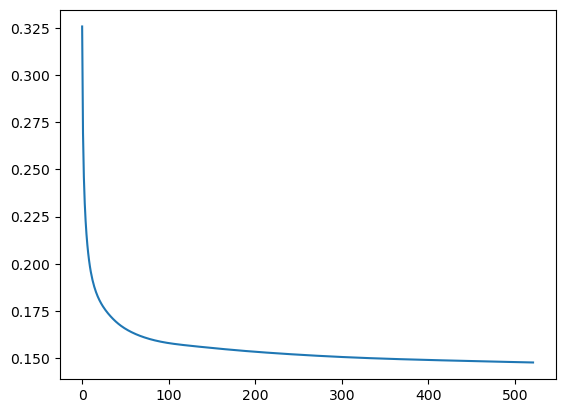

In [658]:
plt.plot(np.array(history)[1:, 0])

In [784]:
def randomized_tensor_CP(X, rank, max_iter=1000, tol=1e-5, n_columns=10):


    normX = linalg.norm(X)
    U = np.array(create_random_tensor(X.shape, rank, normX))


    rel_er, converge_step = 1, tol * 10

    iter = 0
    history = [(rel_er, converge_step, 0)]


    while iter < max_iter and converge_step > tol:
        iter += 1

        # итерируемся по каждой размерности тензора
        for n in range(X.ndim):

            # развертываем матрицу 
            unfold = np.moveaxis(X, n, 0).reshape((X.shape[n], -1))

            # Выбираем две матрицы для закрепления
            components = [U[j] for j in range(X.ndim) if j != n]


            # произведение khatri ra0
            khatri = scipy.linalg.khatri_rao(components[0], components[1]).T

            indices = np.arange(0, khatri.shape[1])
            choice = np.random.choice(indices, size=n_columns)
                          
            khatri = khatri[:, choice]
            unfold = unfold[:, choice]

            # леая и правая части для выражения
            lhs = np.matmul(khatri[None, :, :], khatri.T[None, :, :])
            rhs = np.dot(unfold , khatri.T)[:, :, None]


            # Решаем задачу оптимизации
            U[n] = np.linalg.solve(lhs, rhs).reshape(X.shape[n], rank)


        # считаем ошибку

        rel_er = np.linalg.norm(np.reshape((U[0, :, :] @ scipy.linalg.khatri_rao(U[1, :, :], U[2, :, :]).T), X.shape) - X) / normX
        converge_step = np.abs(rel_er - history[-1][0])
        history.append((rel_er, converge_step, iter))


    return history, np.reshape((U[0, :, :] @ scipy.linalg.khatri_rao(U[1, :, :], U[2, :, :]).T), X.shape)

In [785]:
X = np.random.uniform(1, 10, (25, 25, 25))

In [797]:
history, U = randomized_tensor_CP(X, rank=25, n_columns=600)

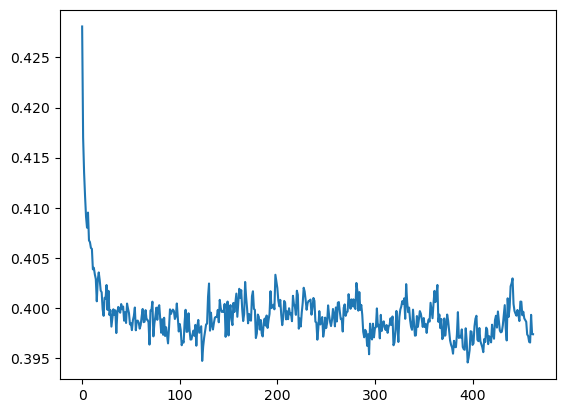

In [798]:
plt.plot(np.array(history)[1:, 0])

In [701]:
np.array(history)[1:-1, 0].min()

0.3953798433291634

In [152]:
def create_random_tensor(shape, rank, norm=None):
    # Генерирует тензор инициализирующих матриц заданного ранга по нормальному распределению
    factors = np.array([np.random.standard_normal((i, rank)) for i in shape])
    if norm is not None:
        C = np.prod([F.T @ F for F in factors], axis=0)
        factors_norm = np.sqrt(np.sum(C))
    
        factors[0] *= norm / factors_norm

    # 
    norms = [np.linalg.norm(f, axis=0) for f in factors]
    lam = np.prod(norms, axis=0) ** (1/len([f.shape[0] for f in factors]))
    factors = [f * (lam / fn) for f, fn in zip(factors, norms)]

    return factors
    

In [389]:
def tensor_CP_3d(X, rank, max_iter=1000, tol=1e-5):


    normX = linalg.norm(X)
    U = np.array(create_random_tensor(X.shape, rank, normX))


    rel_er, converge_step = 1, tol * 10
    #converge_step = tol * 10
    iter = 0
    history = [(rel_er, converge_step, 0)]


    while iter < max_iter and converge_step > tol:
        iter += 1

        # итерируемся по каждой размерности тензора
        for n in range(X.ndim):
            
            # Выбираем две матрицы для закрепления
            components = [U[j] for j in range(X.ndim) if j != n]
            grams = np.prod([u.T @ u for u in components], axis=0)

            
            # произведение khatri ra0
            khatri = scipy.linalg.khatri_rao(components[0], components[1])
            
            # Решаем задачу оптимизации
            U[n] = np.linalg.solve(grams, np.moveaxis(X, n, 0).reshape((X.shape[n], -1)).dot(khatri).T).T

        
        # считаем ошибку
        
        #rel_er = np.sqrt(np.sum(grams) - 2*np.sum(p*U[-1]) + normX**2) / normX
        rel_er = np.linalg.norm(np.reshape((U[0, :, :] @ scipy.linalg.khatri_rao(U[1, :, :], U[2, :, :]).T), X.shape) - X) / normX
        converge_step = np.abs(rel_er - history[-1][0])
        history.append((rel_er, converge_step, iter))

    return history, np.reshape((U[0, :, :] @ scipy.linalg.khatri_rao(U[1, :, :], U[2, :, :]).T), X.shape)

In [702]:
X = np.random.uniform(1, 10, (25, 25, 25))

In [706]:

u = np.random.randint(0, 10, (100))
#v = np.random.randint(0, 10, (100))
#w = np.random.randint(0, 10, (100))
#X = np.einsum('i,j,k',u,u,u)

history, U = tensor_CP_3d(X, rank=25, )

In [707]:
history

[(1, 0.0001, 0),
 (0.41681944898322715, 0.5831805510167729, 1),
 (0.39703282149898095, 0.0197866274842462, 2),
 (0.39063687817866294, 0.006395943320318009, 3),
 (0.3869899858437877, 0.0036468923348752513, 4),
 (0.3845934880945476, 0.002396497749240112, 5),
 (0.3829326759344233, 0.0016608121601242587, 6),
 (0.38168113098688417, 0.0012515449475391516, 7),
 (0.38068630955050464, 0.0009948214363795227, 8),
 (0.3798771554638469, 0.0008091540866577152, 9),
 (0.3792195127967711, 0.0006576426670758528, 10),
 (0.37869139016367853, 0.0005281226330925426, 11),
 (0.37826432905248647, 0.0004270611111920619, 12),
 (0.3779082636931831, 0.00035606535930338135, 13),
 (0.3775987131729434, 0.00030955052023967644, 14),
 (0.3773187029389848, 0.00028001023395862745, 15),
 (0.3770577981208054, 0.00026090481817936384, 16),
 (0.3768103004191869, 0.00024749770161852647, 17),
 (0.3765735848084521, 0.00023671561073479452, 18),
 (0.3763469814587705, 0.0002266033496816089, 19),
 (0.37613120072943135, 0.000215780729

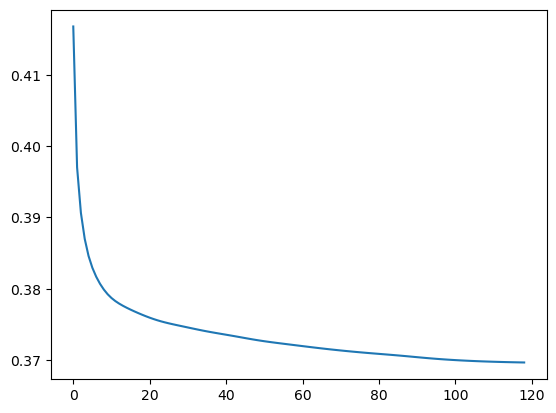

In [708]:
plt.plot(np.array(history)[1:, 0])

In [709]:
np.sum(np.abs(X - U))

29250.31563945292

In [179]:
np.linalg.norm(U - X) / np.linalg.norm(X)

0.1477939670149976

# Работает получше

# nd Tensor CP decomposition (Cholesky)

In [727]:
def khatri_rao(matrices):

    n_columns = matrices[0].shape[1]
    n_factors = len(matrices)

    start = ord('a')
    common_dim = 'z'
    target = ''.join(chr(start + i) for i in range(n_factors))
    source = ','.join(i+common_dim for i in target)
    operation = source+'->'+target+common_dim
    return np.einsum(operation, *matrices).reshape((-1, n_columns))

In [773]:
def tensor_CP_basic_nd(X, rank, max_iter=1000, tol=1e-5):


    normX = linalg.norm(X)
    U = np.array(create_random_tensor(X.shape, rank, normX))


    rel_er, converge_step = 1, tol * 10

    iter = 0
    history = [(rel_er, converge_step, 0)]


    while iter < max_iter and converge_step > tol:
        iter += 1

        # итерируемся по каждой размерности тензора
        for n in range(X.ndim):

            # развертываем матрицу 
            unfold = np.moveaxis(X, n, 0).reshape((X.shape[n], -1))

            # Выбираем две матрицы для закрепления
            components = [U[j] for j in range(X.ndim) if j != n]


            # произведение khatri ra0
            khatri = khatri_rao(components).T

            # леая и правая части для выражения
            lhs = np.matmul(khatri[None, :, :], khatri.T[None, :, :])
            rhs = np.dot(unfold , khatri.T)[:, :, None]


            # Решаем задачу оптимизации
            U[n] = np.linalg.solve(lhs, rhs).reshape(X.shape[n], rank)


        # считаем ошибку

        rel_er = np.linalg.norm(np.reshape((U[0, :, :] @ khatri_rao(U[1:, :, :]).T), X.shape) - X) / normX
        converge_step = np.abs(rel_er - history[-1][0])
        history.append((rel_er, converge_step, iter))


    return history, np.reshape((U[0, :, :] @ khatri_rao(U[1:, :, :]).T), X.shape)

In [735]:
X = np.random.uniform(1, 10, (25, 25, 25, 25))

In [736]:
history, U = tensor_CP_basic_nd(X, rank=25, )

In [737]:
history

[(1, 0.0001, 0),
 (0.43706599169566257, 0.5629340083043375, 1),
 (0.42533355932802225, 0.011732432367640322, 2),
 (0.4249049015183532, 0.000428657809669053, 3),
 (0.4246808108384665, 0.0002240906798867126, 4),
 (0.4245250013957013, 0.00015580944276516462, 5),
 (0.42441427268142884, 0.00011072871427247888, 6),
 (0.42433164762318715, 8.262505824169208e-05, 7),
 (0.4242657364242033, 6.5911198983859e-05, 8),
 (0.4242100243018465, 5.5712122356776916e-05, 9),
 (0.42416114562105683, 4.887868078967683e-05, 10),
 (0.42411801443368163, 4.31311873752005e-05, 11),
 (0.4240809840186762, 3.7030415005412376e-05, 12),
 (0.4240503429025477, 3.064111612854914e-05, 13),
 (0.42402525365650895, 2.508924603872309e-05, 14),
 (0.42400419951974294, 2.1054136766007758e-05, 15),
 (0.42398577279174243, 1.842672800050904e-05, 16),
 (0.423968965671837, 1.6807119905426493e-05, 17),
 (0.4239531551501689, 1.5810521668102595e-05, 18),
 (0.42393804046092803, 1.5114689240869339e-05, 19),
 (0.4239235586234355, 1.448183749

In [390]:
def tensor_CP_nd(X, rank, max_iter=1000, tol=1e-5):


    normX = linalg.norm(X)
    U = np.array(create_random_tensor(X.shape, rank, normX))

    #obj = 10
    iter = 0
    rel_er, converge_step = tol * 10, tol * 10
    history = [(rel_er, converge_step, 0)]

    while iter < max_iter and converge_step > tol:
        iter += 1


        for n in range(X.ndim):
            # итерируемся по каждой размерности тензора

            # Выбираем две матрицы для закрепления
            components = [U[j] for j in range(X.ndim) if j != n]
            grams = np.prod([u.T @ u for u in components], axis=0)

            # произведение khatri ra0
            khatri = khatri_rao(components)

            # Решаем задачу оптимизации 
            c_factors = scipy.linalg.cho_factor(grams, overwrite_a=False)
            unfolding_kh = np.moveaxis(X, n, 0).reshape((X.shape[n], -1)).dot(khatri)
            U[n] = scipy.linalg.cho_solve(c_factors, unfolding_kh.T, overwrite_b=False).T

            
            #U[n] = np.linalg.solve(grams, np.moveaxis(X, n, 0).reshape((X.shape[n], -1)).dot(khatri).T).T


        # считаем ошибку
        #rel_er = np.sqrt(np.sum(grams) - 2*np.sum(p*U[-1]) + normX**2) / normX
        rel_er = np.linalg.norm(np.reshape((U[0, :, :] @ khatri_rao(U[1:, :, :]).T), X.shape) - X) / normX
        converge_step = np.abs(rel_er - history[-1][0])
        history.append((rel_er, converge_step, iter))


    return history, np.reshape((U[0, :, :] @ khatri_rao(U[1:, :, :]).T), X.shape)

In [380]:
X = np.random.uniform(1, 10, (25, 25, 25, 25))

In [381]:
history, U = tensor_CP_nd(X, rank=25, )

In [382]:
np.sum(np.abs(X - U))

870046.7339038772

In [383]:
np.linalg.norm(U - X) / np.linalg.norm(X)

0.4236647120835078

In [384]:
history

[(0.0001, 0.0001, 0),
 (0.44285402573815624, 0.44275402573815625, 1),
 (0.4253036700382355, 0.01755035569992075, 2),
 (0.42480702043607543, 0.0004966496021600597, 3),
 (0.4245733400412701, 0.00023368039480531344, 4),
 (0.4244195111280758, 0.00015382891319432046, 5),
 (0.4243131884959466, 0.00010632263212917437, 6),
 (0.42423558196000916, 7.760653593746891e-05, 7),
 (0.4241718542157106, 6.372774429858064e-05, 8),
 (0.42411646106260964, 5.539315310093551e-05, 9),
 (0.4240679894576446, 4.84716049650169e-05, 10),
 (0.42402524079100234, 4.274866664227828e-05, 11),
 (0.42398670708096525, 3.853371003709194e-05, 12),
 (0.42395141093257077, 3.5296148394481364e-05, 13),
 (0.4239192010757639, 3.2209856806852954e-05, 14),
 (0.4238901876392555, 2.9013436508407153e-05, 15),
 (0.4238642004535242, 2.5987185731324303e-05, 16),
 (0.42384073284510665, 2.346760841753781e-05, 17),
 (0.4238191877512964, 2.154509381024905e-05, 18),
 (0.42379909972708185, 2.0088024214548472e-05, 19),
 (0.4237801358795144, 1.8

In [386]:
X = np.random.uniform(1, 10, (25, 25, 25))
history, U = tensor_CP_nd(X, rank=25, )

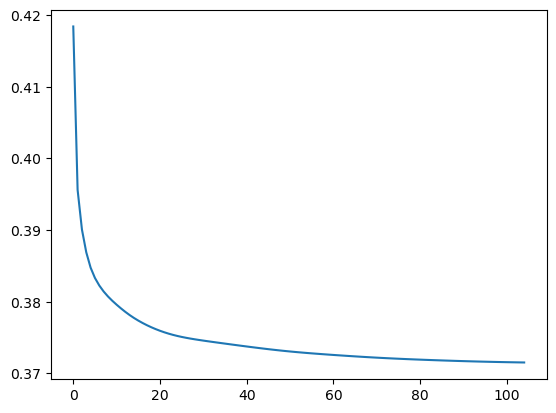

In [387]:
plt.plot(np.array(history)[1:, 0])

# Сравнение двух моделей на 3д тензорах

In [738]:
sizes = [10, 20, 30, 40, 50, 75, 100, 125, 250, 500]

losses_3d = []
losses_nd = []
for size in sizes:
    X = np.random.uniform(1, 10, (size, size, size))
    history, U = tensor_CP_3d(X, rank=25, )
    losses_3d.append(np.array(history)[1:, 0].min())
    history, U = tensor_CP_nd(X, rank=25, )
    losses_nd.append(np.array(history)[1:, 0].min())

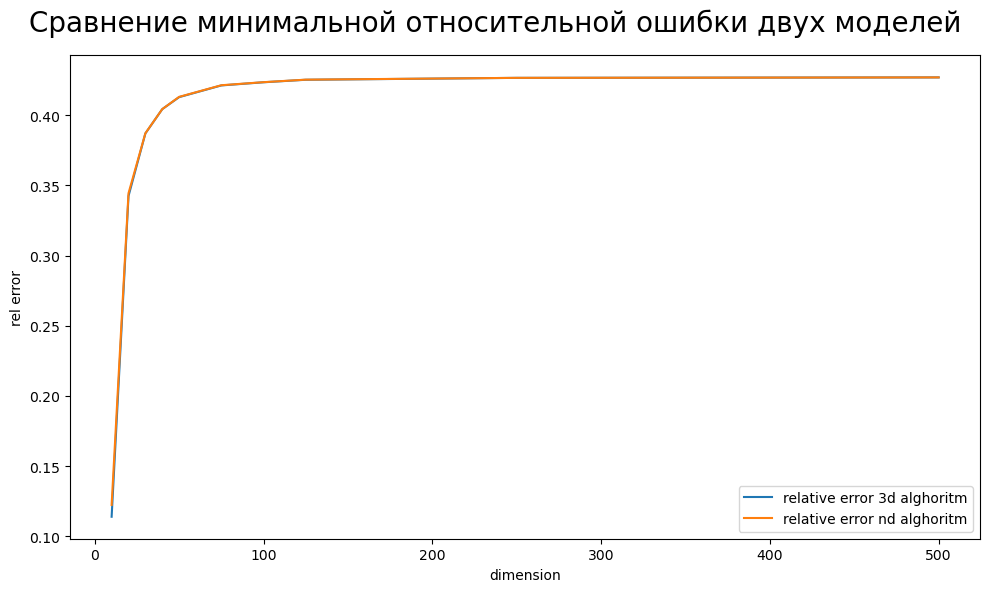

In [739]:
mosaic = '''
QQQ
'''

fig, ax = plt.subplot_mosaic(mosaic=mosaic)


ax['Q'].plot(sizes, losses_3d, label = "relative error 3d alghoritm")
ax['Q'].plot(sizes, losses_nd, label = "relative error nd alghoritm")
ax['Q'].set_ylabel('rel error', fontsize=10)
ax['Q'].set_xlabel('dimension', fontsize=10)
ax['Q'].legend()

fig.suptitle('Сравнение минимальной относительной ошибки двух моделей', fontsize=20)
fig.set_size_inches(10, 6)
fig.tight_layout()

plt.show()

In [740]:
sizes = [10, 20, 30, 40, 50, 75, 100, 125, 250, 500]

times_3d = []
times_nd = []
for size in sizes:
    X = np.random.uniform(1, 10, (size, size, size))
    
    time_3d = %timeit -n1 -o -q tensor_CP_3d(X, rank=25, )
    times_3d.append(time_3d.average)

    time_nd = %timeit -n1 -o -q tensor_CP_nd(X, rank=25, )
    times_nd.append(time_nd.average)



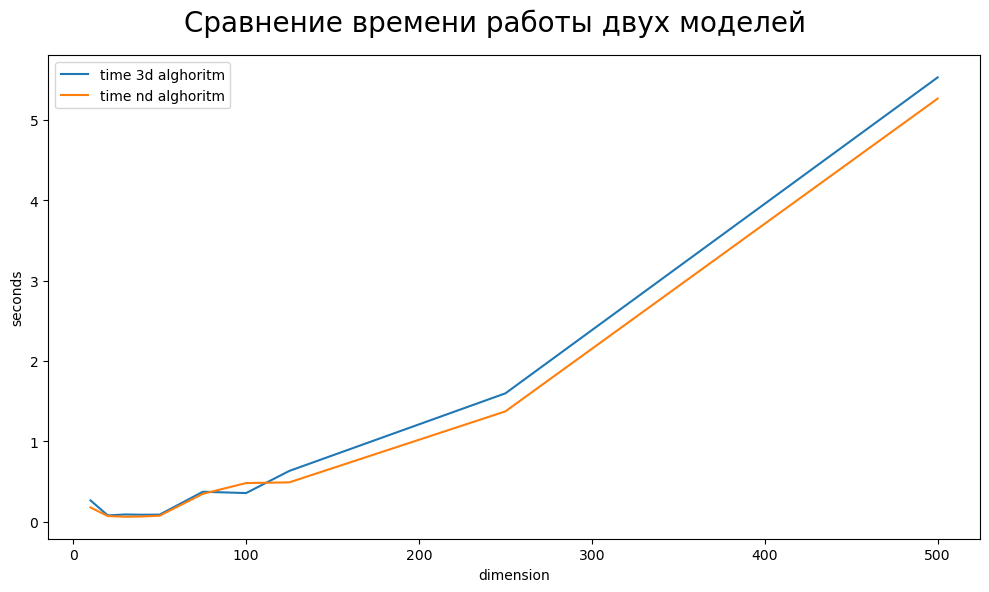

In [741]:
mosaic = '''
QQQ
'''

fig, ax = plt.subplot_mosaic(mosaic=mosaic)


ax['Q'].plot(sizes, times_3d, label = "time 3d alghoritm")
ax['Q'].plot(sizes, times_nd, label = "time nd alghoritm")
ax['Q'].set_ylabel('seconds', fontsize=10)
ax['Q'].set_xlabel('dimension', fontsize=10)
ax['Q'].legend()

fig.suptitle('Сравнение времени работы двух моделей', fontsize=20)
fig.set_size_inches(10, 6)
fig.tight_layout()

plt.show()

Разницы между моделями нет, кроме того, что вторая работает на nd тензорах

# Randomized Matrix Least squares acceleration (np.lstsq) for 3d tensors

In [404]:
def tensor_CP_randomized(X, rank, max_iter=1000, tol=1e-5, n_columns = 10):


    normX = linalg.norm(X)
    U = np.array(create_random_tensor(X.shape, rank, normX))


    rel_er, converge_step = tol * 10, tol * 10
    #converge_step = tol * 10
    iter = 0
    history = [(rel_er, converge_step, 0)]


    while iter < max_iter and converge_step > tol:
        iter += 1

        # итерируемся по каждой размерности тензора
        for n in range(X.ndim):

            # Выбираем две матрицы для закрепления
            components = [U[j] for j in range(X.ndim) if j != n]
            grams = np.prod([u.T @ u for u in components], axis=0)

            indices = np.arange(0, grams.shape[0])
            choice = np.random.choice(indices, size=n_columns)
            
            
            # произведение khatri ra0
            khatri = scipy.linalg.khatri_rao(components[0], components[1])            
            # Решаем задачу оптимизации
            U[n] = np.linalg.lstsq(grams[choice, :], (np.moveaxis(X, n, 0).reshape((X.shape[n], -1)).dot(khatri).T)[choice, :], rcond=None)[0].T


        # считаем ошибку

        #rel_er = np.sqrt(np.sum(grams) - 2*np.sum(p*U[-1]) + normX**2) / normX
        rel_er = np.linalg.norm(np.reshape((U[0, :, :] @ scipy.linalg.khatri_rao(U[1, :, :], U[2, :, :]).T), X.shape) - X) / normX
        converge_step = np.abs(rel_er - history[-1][0])
        history.append((rel_er, converge_step, iter))

    return history, np.reshape((U[0, :, :] @ scipy.linalg.khatri_rao(U[1, :, :], U[2, :, :]).T), X.shape)

In [405]:
X = np.random.uniform(1, 10, (225, 225, 225))

In [406]:
history, U = tensor_CP_randomized(X, rank=25, )

In [407]:
history

[(0.0001, 0.0001, 0),
 (0.47948911478234163, 0.47938911478234164, 1),
 (0.4308202055723582, 0.04866890920998346, 2),
 (0.4343920388656698, 0.0035718332933116215, 3),
 (0.4279818834595823, 0.00641015540608747, 4),
 (0.4273325655087545, 0.0006493179508278435, 5),
 (0.4271349067529607, 0.00019765875579380587, 6),
 (0.4271525634790066, 1.765672604592261e-05, 7),
 (0.4289284518922052, 0.0017758884131985897, 8),
 (0.42715745953490736, 0.0017709923572978292, 9),
 (0.4271574593653865, 1.6952084180843485e-10, 10)]

# Тесты

In [742]:
sizes = [10, 20, 30, 40, 50, 75, 100, 125, 250, 500]

losses_3d = []
losses_nd = []
losses_rand = []
for size in sizes:
    X = np.random.uniform(1, 10, (size, size, size))
    history, U = tensor_CP_3d(X, rank=25, )
    losses_3d.append(np.array(history)[1:, 0].min())
    history, U = tensor_CP_nd(X, rank=25, )
    losses_nd.append(np.array(history)[1:, 0].min())
    history, U = tensor_CP_randomized(X, rank=25, )
    losses_rand.append(np.array(history)[1:, 0].min())

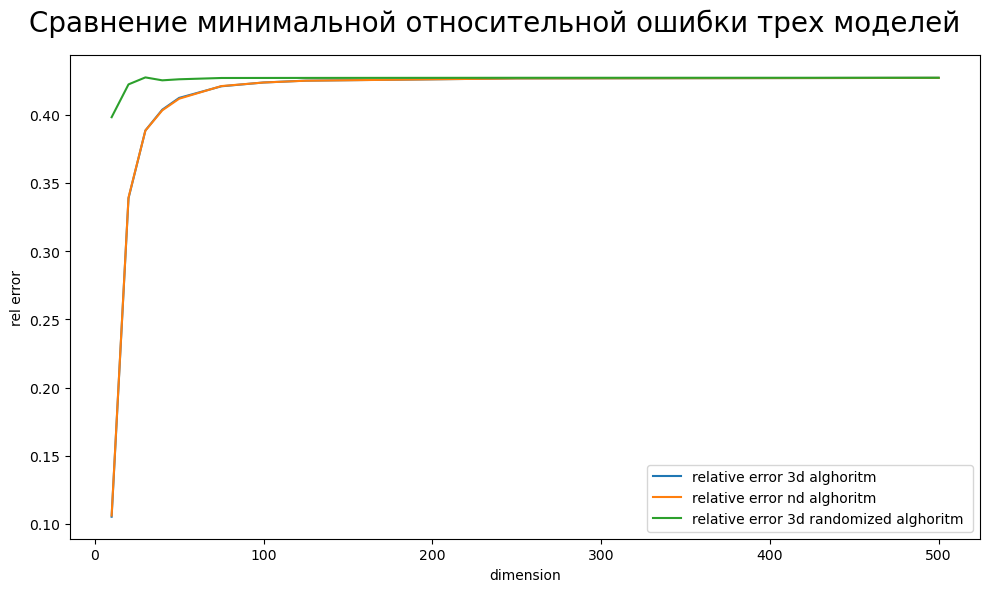

In [743]:
mosaic = '''
QQQ
'''

fig, ax = plt.subplot_mosaic(mosaic=mosaic)


ax['Q'].plot(sizes, losses_3d, label = "relative error 3d alghoritm")
ax['Q'].plot(sizes, losses_nd, label = "relative error nd alghoritm")
ax['Q'].plot(sizes, losses_rand, label = "relative error 3d randomized alghoritm ")
ax['Q'].set_ylabel('rel error', fontsize=10)
ax['Q'].set_xlabel('dimension', fontsize=10)
ax['Q'].legend()

fig.suptitle('Сравнение минимальной относительной ошибки трех моделей', fontsize=20)
fig.set_size_inches(10, 6)
fig.tight_layout()

plt.show()

In [744]:
sizes = [10, 20, 30, 40, 50, 75, 100, 125, 250, 500]

times_3d = []
times_nd = []
times_rand = []
for size in sizes:
    X = np.random.uniform(1, 10, (size, size, size))

    time_3d = %timeit -n1 -o -q tensor_CP_3d(X, rank=25, )
    times_3d.append(time_3d.average)

    time_nd = %timeit -n1 -o -q tensor_CP_nd(X, rank=25, )
    times_nd.append(time_nd.average)
    time_rand = %timeit -n1 -o -q tensor_CP_randomized(X, rank=25, )
    times_rand.append(time_rand.average)



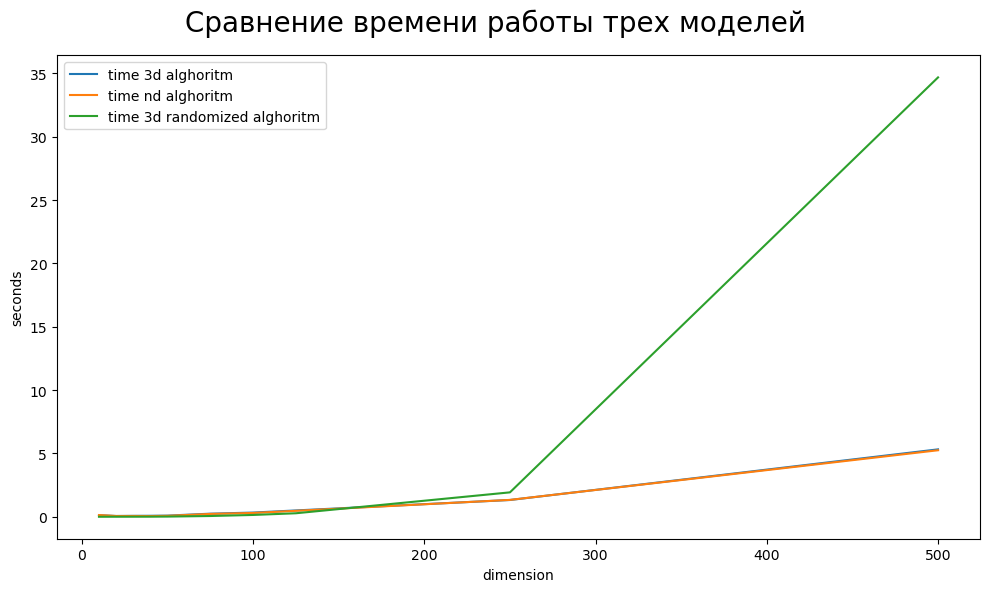

In [745]:
mosaic = '''
QQQ
'''

fig, ax = plt.subplot_mosaic(mosaic=mosaic)


ax['Q'].plot(sizes, times_3d, label = "time 3d alghoritm")
ax['Q'].plot(sizes, times_nd, label = "time nd alghoritm")
ax['Q'].plot(sizes, times_rand, label = "time 3d randomized alghoritm")
ax['Q'].set_ylabel('seconds', fontsize=10)
ax['Q'].set_xlabel('dimension', fontsize=10)
ax['Q'].legend()

fig.suptitle('Сравнение времени работы трех моделей', fontsize=20)
fig.set_size_inches(10, 6)
fig.tight_layout()

plt.show()

# Что-то пошло не так, рандомизация только увеличила время работы

In [ ]:
n_columns = 10

In [746]:
sizes = [10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 225, 250]

times_3d = []
times_nd = []
times_rand = []
for size in sizes:
    X = np.random.uniform(1, 10, (size, size, size))

    time_nd = %timeit -n1 -o -q tensor_CP_nd(X, rank=25, )
    times_nd.append(time_nd.average)
    
    time_rand = %timeit -n1 -o -q tensor_CP_randomized(X, rank=25, n_columns = int(size / 4))
    times_rand.append(time_rand.average)


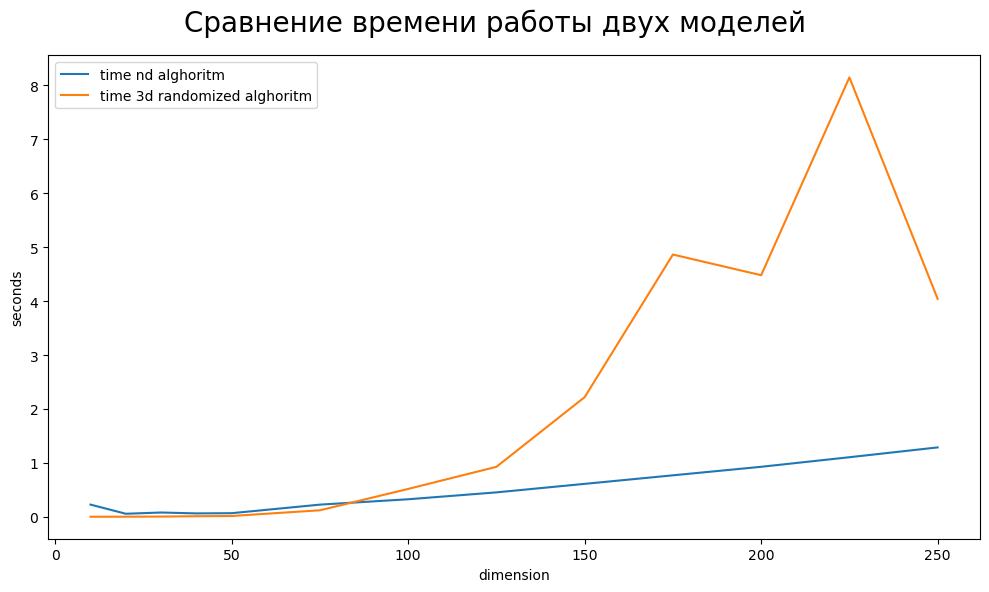

In [747]:
mosaic = '''
QQQ
'''

fig, ax = plt.subplot_mosaic(mosaic=mosaic)


ax['Q'].plot(sizes, times_nd, label = "time nd alghoritm")
ax['Q'].plot(sizes, times_rand, label = "time 3d randomized alghoritm")
ax['Q'].set_ylabel('seconds', fontsize=10)
ax['Q'].set_xlabel('dimension', fontsize=10)
ax['Q'].legend()

fig.suptitle('Сравнение времени работы двух моделей', fontsize=20)
fig.set_size_inches(10, 6)
fig.tight_layout()

plt.show()

In [637]:
def tensor_CP_randomized(X, rank, max_iter=1000, tol=1e-5, n_columns = 10):


    normX = linalg.norm(X)
    U = np.array(create_random_tensor(X.shape, rank, normX))


    rel_er, converge_step = tol * 10, tol * 10
    #converge_step = tol * 10
    iter = 0
    history = [(rel_er, converge_step, 0)]


    while iter < max_iter and converge_step > tol:
        iter += 1

        # итерируемся по каждой размерности тензора
        for n in range(X.ndim):

            # Выбираем две матрицы для закрепления
            components = [U[j] for j in range(X.ndim) if j != n]
            #dim = u.shape[0]
            indices = np.arange(0, components[0].shape[1])
            choice = np.random.choice(indices, size=n_columns)
            grams = np.prod([(u[:, choice]).T @ u for u in components], axis=0)

            #indices = np.arange(0, grams.shape[0])
            #choice = np.random.choice(indices, size=n_columns)

            # произведение khatri ra0
            khatri = scipy.linalg.khatri_rao(components[0][:, choice], components[1][:, choice])
            # Решаем задачу оптимизации
            U[n] = np.linalg.lstsq(grams, (np.moveaxis(X, n, 0).reshape((X.shape[n], -1)).dot(khatri).T), rcond=None)[0].T


        # считаем ошибку

        #rel_er = np.sqrt(np.sum(grams) - 2*np.sum(p*U[-1]) + normX**2) / normX
        rel_er = np.linalg.norm(np.reshape((U[0, :, :] @ scipy.linalg.khatri_rao(U[1, :, :], U[2, :, :]).T), X.shape) - X) / normX
        converge_step = np.abs(rel_er - history[-1][0])
        history.append((rel_er, converge_step, iter))

    return history, np.reshape((U[0, :, :] @ scipy.linalg.khatri_rao(U[1, :, :], U[2, :, :]).T), X.shape)

In [638]:
X = np.random.uniform(1, 10, (130, 130, 130))

In [639]:
history, U = tensor_CP_randomized(X, rank=25, )

In [538]:
history

[(0.0001, 0.0001, 0),
 (0.4450280732663264, 0.4449280732663264, 1),
 (0.4261659910200814, 0.01886208224624497, 2),
 (0.42590665626677343, 0.0002593347533079715, 3),
 (0.4257785365277924, 0.00012811973898102513, 4),
 (0.4256966112345316, 8.192529326078724e-05, 5),
 (0.42563724667930997, 5.9364555221652626e-05, 6),
 (0.4255893197836145, 4.792689569549369e-05, 7),
 (0.42554781549822684, 4.150428538762796e-05, 8),
 (0.4255108676602387, 3.6947837988132726e-05, 9),
 (0.4254779284243189, 3.293923591979331e-05, 10),
 (0.42544884015991385, 2.9088264405063846e-05, 11),
 (0.42542353452550147, 2.530563441238698e-05, 12),
 (0.4254018692705757, 2.166525492575122e-05, 13),
 (0.4253834795077745, 1.8389762801218623e-05, 14),
 (0.42536779420918724, 1.5685298587253538e-05, 15),
 (0.4253542058044571, 1.3588404730147108e-05, 16),
 (0.4253422221485688, 1.198365588828132e-05, 17),
 (0.4253315034734802, 1.0718675088616791e-05, 18),
 (0.425321820094826, 9.683378654201658e-06, 19)]

In [593]:
sizes = [30, 40, 50, 75, 100, 125, 150, 200,]

times_3d = []
times_nd = []
times_rand = []
for size in sizes:
    X = np.random.uniform(1, 10, (size, size, size))
    print(size)

    time_nd = %timeit -n1 -o -q tensor_CP_nd(X, rank=25, )
    times_nd.append(time_nd.average)

    time_rand = %timeit -n1 -o -q tensor_CP_randomized(X, rank=25, n_columns = 20)
    times_rand.append(time_rand.average)


30
40
50
75
100
125
150
200


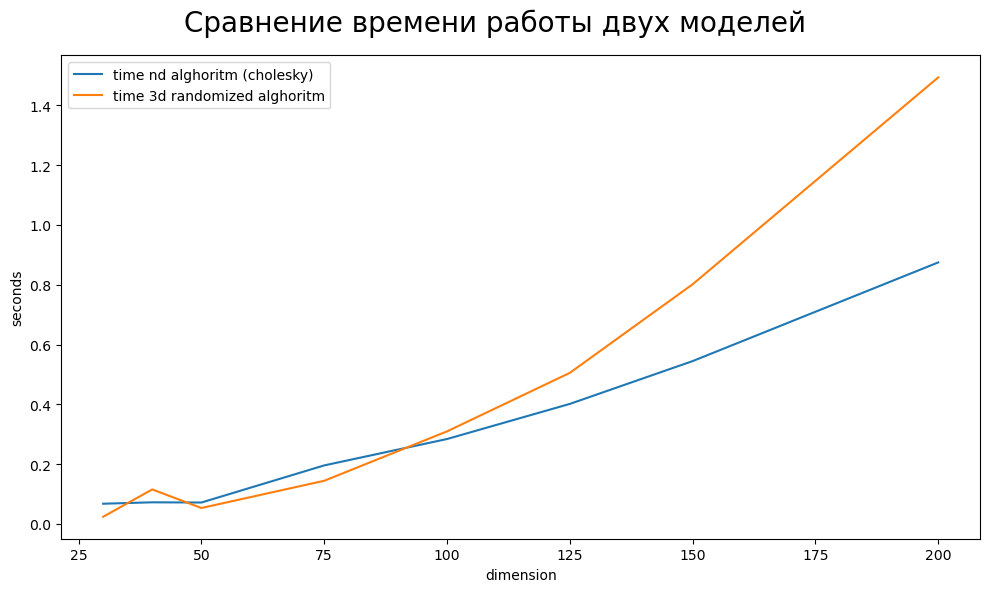

In [594]:
mosaic = '''
QQQ
'''

fig, ax = plt.subplot_mosaic(mosaic=mosaic)


ax['Q'].plot(sizes, times_nd, label = "time nd alghoritm (cholesky)")
ax['Q'].plot(sizes, times_rand, label = "time 3d randomized alghoritm")
ax['Q'].set_ylabel('seconds', fontsize=10)
ax['Q'].set_xlabel('dimension', fontsize=10)
ax['Q'].legend()

fig.suptitle('Сравнение времени работы двух моделей', fontsize=20)
fig.set_size_inches(10, 6)
fig.tight_layout()

plt.show()

# Рандомайзинг в альтернативной модели работает не слишком хорошо

Сравнение всех моделей

In [799]:
sizes = [10, 20, 30, 40, 50, 75, 100, 125]

losses = []
rand_losses = []
losses_nd = []
losses_rand = []
for size in sizes:
    X = np.random.uniform(1, 10, (size, size, size))
    history, U = tensor_CP(X, rank=25, )
    losses.append(np.array(history)[1:, 0].min())

    history, U = randomized_tensor_CP(X, rank=25, )
    rand_losses.append(np.array(history)[1:, 0].min())
    
    
    
    X = np.random.uniform(1, 10, (size, size, size))
    history, U = tensor_CP_nd(X, rank=25, )
    losses_nd.append(np.array(history)[1:, 0].min())
    history, U = tensor_CP_randomized(X, rank=25, )
    losses_rand.append(np.array(history)[1:, 0].min())
    
    

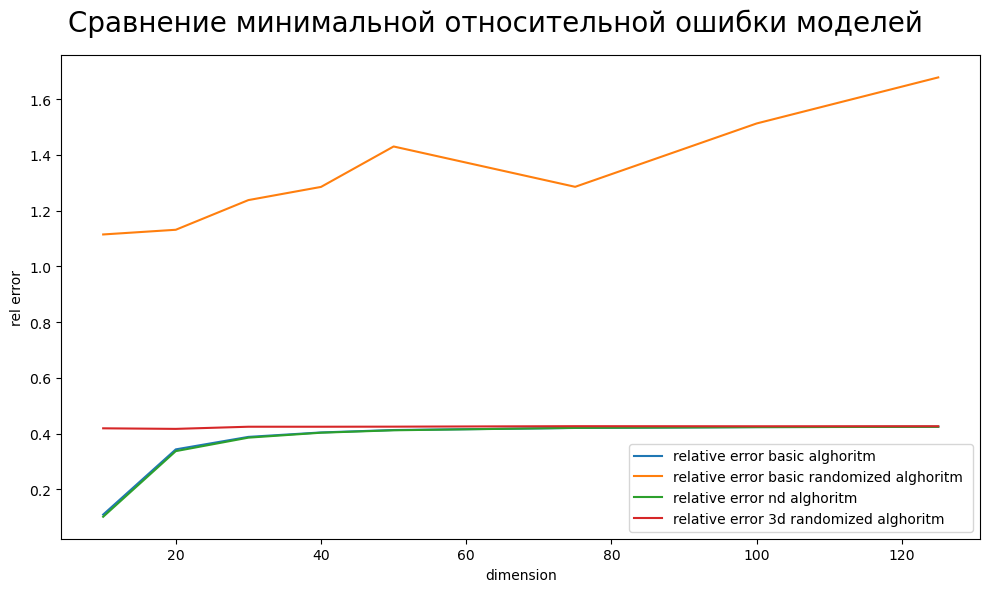

In [800]:
mosaic = '''
QQQ
'''

fig, ax = plt.subplot_mosaic(mosaic=mosaic)

ax['Q'].plot(sizes, losses, label = "relative error basic alghoritm ")
ax['Q'].plot(sizes, rand_losses, label = "relative error basic randomized alghoritm ")

ax['Q'].plot(sizes, losses_nd, label = "relative error nd alghoritm")
ax['Q'].plot(sizes, losses_rand, label = "relative error 3d randomized alghoritm ")
ax['Q'].set_ylabel('rel error', fontsize=10)
ax['Q'].set_xlabel('dimension', fontsize=10)
ax['Q'].legend()

fig.suptitle('Сравнение минимальной относительной ошибки моделей', fontsize=20)
fig.set_size_inches(10, 6)
fig.tight_layout()

plt.show()

In [754]:
sizes = [30, 40, 50, 75, 100, 125, 150,]

times_basic = []
times_basic_randomized = []
times_nd = []
times_rand = []
for size in sizes:
    X = np.random.uniform(1, 10, (size, size, size))
    print(size)

    time_b = %timeit -n1 -o -q tensor_CP(X, rank=25, )
    times_basic.append(time_b.average)

    time_b_r = %timeit -n1 -o -q randomized_tensor_CP(X, rank=25, )
    times_basic_randomized.append(time_b_r.average)

    time_nd = %timeit -n1 -o -q tensor_CP_nd(X, rank=25, )
    times_nd.append(time_nd.average)

    time_rand = %timeit -n1 -o -q tensor_CP_randomized(X, rank=25, n_columns = 20)
    times_rand.append(time_rand.average)

30
40
50
75
100
125
150


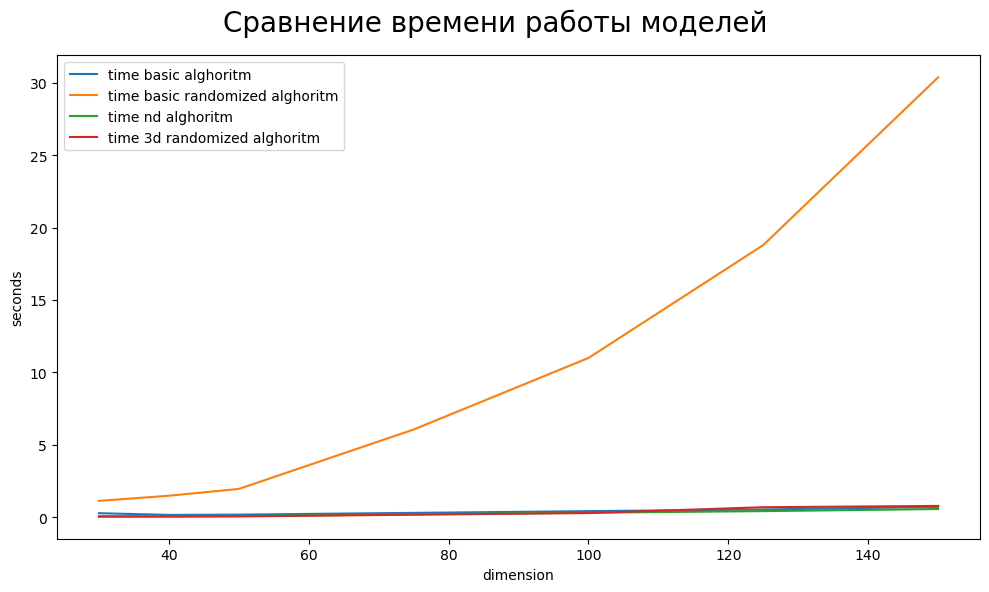

In [755]:
mosaic = '''
QQQ
'''

fig, ax = plt.subplot_mosaic(mosaic=mosaic)

ax['Q'].plot(sizes, times_basic, label = "time basic alghoritm ")
ax['Q'].plot(sizes, times_basic_randomized, label = "time basic randomized alghoritm")
ax['Q'].plot(sizes, times_nd, label = "time nd alghoritm")
ax['Q'].plot(sizes, times_rand, label = "time 3d randomized alghoritm")
ax['Q'].set_ylabel('seconds', fontsize=10)
ax['Q'].set_xlabel('dimension', fontsize=10)
ax['Q'].legend()

fig.suptitle('Сравнение времени работы моделей', fontsize=20)
fig.set_size_inches(10, 6)
fig.tight_layout()

plt.show()

In [762]:
sizes = [30, 40, 50, 75, 100, 125, 150, 175, 200]

times_basic = []
times_basic_randomized = []
times_nd = []
times_rand = []
for size in sizes:
    X = np.random.uniform(1, 10, (size, size, size))
    print(size)

    time_b = %timeit -n1 -o -q tensor_CP(X, rank=25, )
    times_basic.append(time_b.average)

    time_nd = %timeit -n1 -o -q tensor_CP_nd(X, rank=25, )
    times_nd.append(time_nd.average)

    time_rand = %timeit -n1 -o -q tensor_CP_randomized(X, rank=25, n_columns = 20)
    times_rand.append(time_rand.average)

30
40
50
75
100
125
150
175
200


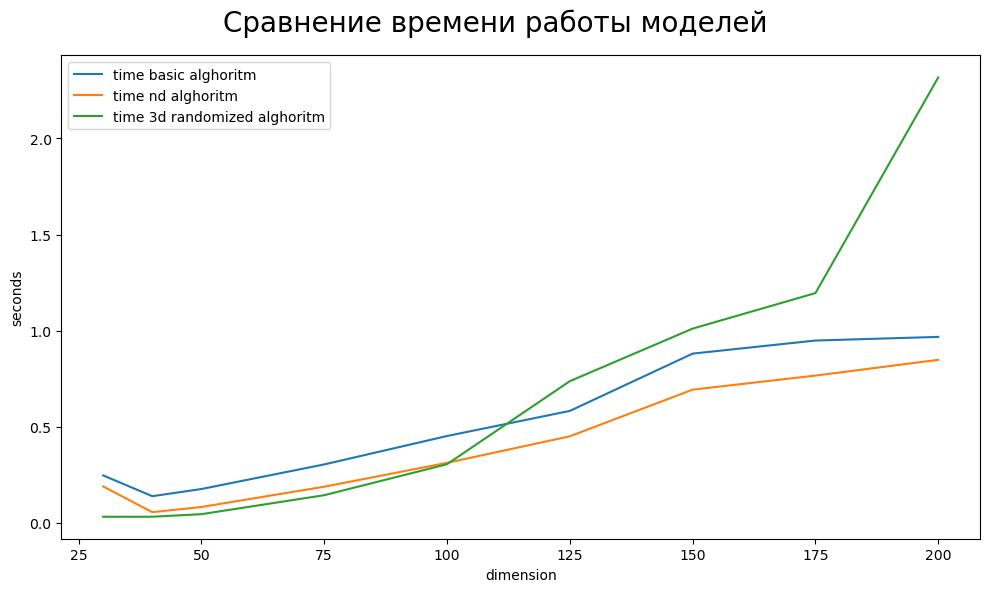

In [763]:
mosaic = '''
QQQ
'''

fig, ax = plt.subplot_mosaic(mosaic=mosaic)

ax['Q'].plot(sizes, times_basic, label = "time basic alghoritm ")
ax['Q'].plot(sizes, times_nd, label = "time nd alghoritm")
ax['Q'].plot(sizes, times_rand, label = "time 3d randomized alghoritm")
ax['Q'].set_ylabel('seconds', fontsize=10)
ax['Q'].set_xlabel('dimension', fontsize=10)
ax['Q'].legend()

fig.suptitle('Сравнение времени работы моделей', fontsize=20)
fig.set_size_inches(10, 6)
fig.tight_layout()

plt.show()

In [767]:
size = 25

ranks = [1, 5, 15, 35, 50,  60, 75, 90, 100, 110]

losses = []
losses_upd = []
for rank in ranks:
    X = np.random.uniform(1, 10, (size, size, size))
    history, U = tensor_CP(X, rank=rank, )
    losses.append(np.array(history)[1:, 0].min())

    history, U = tensor_CP_nd(X, rank=rank, )
    losses_upd.append(np.array(history)[1:, 0].min())


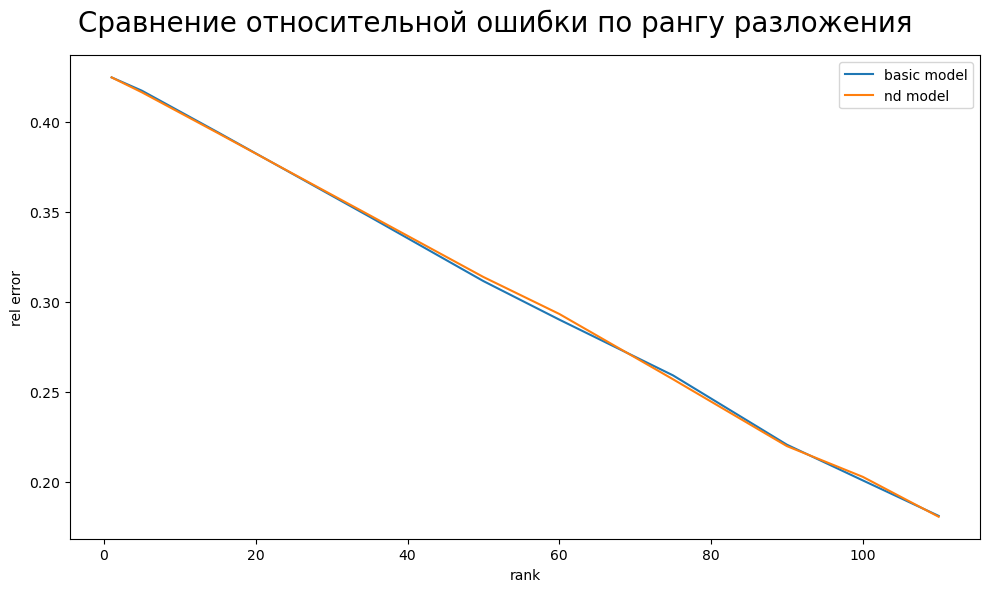

In [768]:
mosaic = '''
QQQ
'''

fig, ax = plt.subplot_mosaic(mosaic=mosaic)

ax['Q'].plot(ranks, losses, label = "basic model")
ax['Q'].plot(ranks, losses_upd, label = "nd model")

ax['Q'].set_ylabel('rel error', fontsize=10)
ax['Q'].set_xlabel('rank', fontsize=10)
ax['Q'].legend()

fig.suptitle('Сравнение относительной ошибки по рангу разложения', fontsize=20)
fig.set_size_inches(10, 6)
fig.tight_layout()

plt.show()

In [770]:
(5,) * 3

(5, 5, 5)

In [781]:
size = 15

times_basic = []

for d in range(3, 7):
    print(d)
    X = np.random.uniform(1, 10, (size,) * d)

    time_b = %timeit -n1 -o -q tensor_CP_basic_nd(X, rank=25, )
    times_basic.append(time_b.average)



3
4
5
6


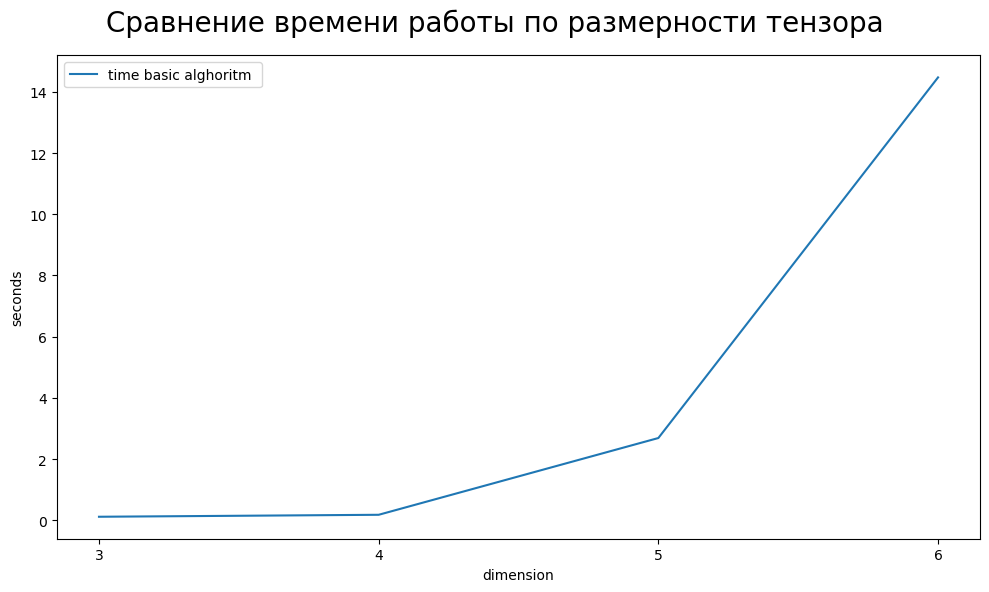

In [783]:
mosaic = '''
QQQ
'''

fig, ax = plt.subplot_mosaic(mosaic=mosaic)

ax['Q'].plot([d for d in range(3, 7)], times_basic, label = "time basic alghoritm "),
ax['Q'].set_ylabel('seconds', fontsize=10)
ax['Q'].set_xlabel('dimension', fontsize=10)
plt.xticks([d for d in range(3, 7)])
ax['Q'].legend()

fig.suptitle('Сравнение времени работы по размерности тензора', fontsize=20)
fig.set_size_inches(10, 6)
fig.tight_layout()

plt.show()